# **Project: Amazon Product Recommendation System**

# **Marks: 40**


Welcome to the project on Recommendation Systems. We will work with the Amazon product reviews dataset for this project. The dataset contains ratings of different electronic products. It does not include information about the products or reviews to avoid bias while building the model.

--------------
## **Context:**
--------------

Today, information is growing exponentially with volume, velocity and variety throughout the globe. This has lead to information overload, and too many choices for the consumer of any business. It represents a real dilemma for these consumers and they often turn to denial. Recommender Systems are one of the best tools that help recommending products to consumers while they are browsing online. Providing personalized recommendations which is most relevant for the user is what's most likely to keep them engaged and help business.

E-commerce websites like Amazon, Walmart, Target and Etsy use different recommendation models to provide personalized suggestions to different users. These companies spend millions of dollars to come up with algorithmic techniques that can provide personalized recommendations to their users.

Amazon, for example, is well-known for its accurate selection of recommendations in its online site. Amazon's recommendation system is capable of intelligently analyzing and predicting customers' shopping preferences in order to offer them a list of recommended products. Amazon's recommendation algorithm is therefore a key element in using AI to improve the personalization of its website. For example, one of the baseline recommendation models that Amazon uses is item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

----------------
## **Objective:**
----------------

You are a Data Science Manager at Amazon, and have been given the task of building a recommendation system to recommend products to customers based on their previous ratings for other products. You have a collection of labeled data of Amazon reviews of products. The goal is to extract meaningful insights from the data and build a recommendation system that helps in recommending products to online consumers.

-----------------------------
## **Dataset:**
-----------------------------

The Amazon dataset contains the following attributes:

- **userId:** Every user identified with a unique id
- **productId:** Every product identified with a unique id
- **Rating:** The rating of the corresponding product by the corresponding user
- **timestamp:** Time of the rating. We **will not use this column** to solve the current problem

**Note:** The code has some user defined functions that will be usefull while making recommendations and measure model performance, you can use these functions or can create your own functions.

Sometimes, the installation of the surprise library, which is used to build recommendation systems, faces issues in Jupyter. To avoid any issues, it is advised to use **Google Colab** for this project.

Let's start by mounting the Google drive on Colab.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Installing surprise library**

In [2]:
!pip install surprise

## **Importing the necessary libraries and overview of the dataset**

In [3]:
# importing libraries for reading the data
import pandas as pd
import numpy as np

# importing libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# importing defaultdict dictionary sub-class to avoid KeyError
from collections import defaultdict

# code to ignore warnings
import warnings
warnings.filterwarnings('ignore')


### **Loading the data**


In [4]:
# importing the dataset
data = pd.read_csv('/content/drive/MyDrive/MIT IDSS Python/ratings_Electronics.csv', header = None) # There are no headers in the data file

There are no column names in the dataset. Let's add them.

In [5]:
# adding column names to the dataset
data.columns = ['user_id', 'prod_id', 'rating', 'timestamp']

In [6]:
# viewing the first 5 rows of the dataset
data.head()

,user_id,prod_id,rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


Let's drop the timestamp column as it is not needed for the current problem and make a working copy of the dataset.

In [7]:
# dropping the column timestamp as it is not needed for the current problem
data.drop(['timestamp'], axis = 1, inplace = True)

# making a copy of the dataset
df = data.copy()

# viewing the first 5 rows of the copied dataset
df.head()

,user_id,prod_id,rating
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0


In [8]:
# checking the shape of the dataset
df.shape

(7824482, 3)

**As this dataset is very large and has 7,824,482 observations, it is not computationally possible to build a model using this. Moreover, many users have only rated a few products and also some products are rated by very few users. Hence, we can reduce the dataset by considering certain logical assumptions.**

Here, we will be taking users who have given at least 50 ratings, and the products that have at least 5 ratings, as when we shop online we prefer to have some number of ratings of a product.

In [9]:
# Get the column containing the users
users = df.user_id

# Create a dictionary from users to their number of ratings
ratings_count = dict()

for user in users:

    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1

In [10]:
# We want our users to have at least 50 ratings to be considered
RATINGS_CUTOFF = 50

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df = df.loc[ ~ df.user_id.isin(remove_users)]

In [11]:
# Get the column containing the products
prods = df.prod_id

# Create a dictionary from products to their number of ratings
ratings_count = dict()

for prod in prods:

    # If we already have the product, just add 1 to its rating count
    if prod in ratings_count:
        ratings_count[prod] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[prod] = 1

In [12]:
# We want our item to have at least 5 ratings to be considered
RATINGS_CUTOFF = 5

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df_final = df.loc[~ df.prod_id.isin(remove_users)]

In [13]:
# Printing a few rows of the imported dataset
df_final.head()

,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5.0
1322,A1A5KUIIIHFF4U,1400501466,1.0
1335,A2XIOXRRYX0KZY,1400501466,3.0
1451,AW3LX47IHPFRL,1400501466,5.0
1456,A1E3OB6QMBKRYZ,1400501466,1.0


## **Exploratory Data Analysis**

### **Shape of the data**

In [14]:
# Checking the number of rows and columns and provide observations
print (f'The new dataset has {df_final.shape[0]} rows.')
print (f'The dataset has {df_final.shape[1]} columns.')

The new dataset has 65290 rows.
The dataset has 3 columns.


**Observations:**

* The dataset has been reduced to **65920 rows of observations** from the initial > 7 million observations using cutoffs to select only users that have given at least 50 ratings and products that have at least 5 ratings.
* The dataset has **3 columns**.

### **Data types**

In [15]:
# Checking Data types and provide observations
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65290 entries, 1310 to 7824427
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  65290 non-null  object 
 1   prod_id  65290 non-null  object 
 2   rating   65290 non-null  float64
dtypes: float64(1), object(2)
memory usage: 2.0+ MB


**Observations:**
* Both user_id and prod_id are object type data.
* **Rating** is the only numerical data column with a float datatype.

### **Checking for missing values**

In [16]:
# Checking for missing values present and provide observations
df_final.isnull().sum()

user_id    0
prod_id    0
rating     0
dtype: int64

**Observations:**
* There are no missing values in the reduced dataset.

In [17]:
# Checking for duplicates
df_final.duplicated().sum()

0

**Observations:**
- There are no duplicate user-item pairs in the dataset indicating that each observation is a **unique interaction**.

### **Summary Statistics**

In [18]:
# Summary statistics of 'rating' variable and provide observations
df_final['rating'].describe()

count    65290.000000
mean         4.294808
std          0.988915
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: rating, dtype: float64

**Observations:**
* The **average rating** of products given by users is **~4.29**.
* Over **75% of users** have rated products **above 4.0** with **over 50%** users giving a rating of **5.0** to the products.
* The above observation is interesting as it indicates that more people rate a product when they are satisfied/happy with it.
* The minimum rating is 1.0 and the maximum is 5.0.

### **Checking the rating distribution**

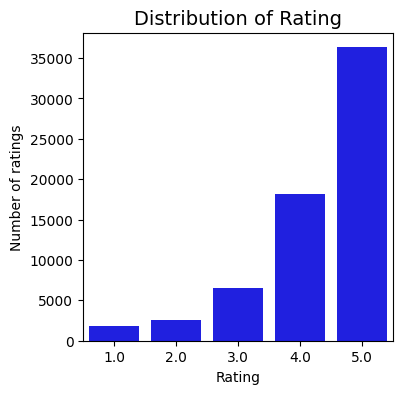

In [19]:
# Creating the bar plot and provide observations
plt.figure(figsize = (4,4))
sns.countplot(data = df_final, x = 'rating', color = 'blue')
plt.tick_params(labelsize = 10)                   # code here and below is for adding additional formatting to the chart.
plt.title('Distribution of Rating', fontsize = 14)
plt.ylabel('Number of ratings', fontsize = 10)
plt.xlabel('Rating', fontsize = 10)
plt.show()

**Observations:**
* According to the plot, rating 5.0 has the highest count of ratings with over 35K followed by rating 4.0 with ~18K ratings.
* There are less than 2500 ratings each for rating 1.0 and 2.0.



### **Checking the number of unique users and items in the dataset**

In [20]:
# Number of total rows in the data and number of unique user id and product id in the data
print (f'There are {df_final.user_id.nunique()} unique users in the dataset.')
print (f'There are {df_final.prod_id.nunique()} unique products in the dataset.')

There are 1540 unique users in the dataset.
There are 5689 unique products in the dataset.


**Observations:**
* The dataset we are using has **1540 unique users** that have rated 50 or more products in the dataset.
* The dataset has **5689 unique products** that have been rated 5 or more times.

### **Users with the most number of ratings**

In [21]:
# Top 10 users based on the number of ratings
df_final.groupby(['user_id'])['rating'].count().nlargest(10)


user_id
ADLVFFE4VBT8      295
A3OXHLG6DIBRW8    230
A1ODOGXEYECQQ8    217
A36K2N527TXXJN    212
A25C2M3QF9G7OQ    203
A680RUE1FDO8B     196
A1UQBFCERIP7VJ    193
A22CW0ZHY3NJH8    193
AWPODHOB4GFWL     184
A3LGT6UZL99IW1    179
Name: rating, dtype: int64

**Observations:**
* User "ADLVFFE4VBT8" has the highest number of ratings and has rated **295** products.
* This is a fraction of the total products in the dataset and indicates that not all users interact with all products.
* Thus we can build recommendation systems to recommend products that users haven't interacted with to them.

**Now that we have explored and prepared the data, let's build the first recommendation system.**

## **Model 1: Rank Based Recommendation System**

In [22]:
# Calculate the average rating for each product
average_rating = df_final.groupby(['prod_id']).rating.mean()

# Calculate the count of ratings for each product
rating_count = df_final.groupby(['prod_id']).rating.count()

# Create a dataframe with calculated average and count of ratings
final_rating = pd.DataFrame({'average_rating': average_rating, 'rating_count': rating_count})

# Sort the dataframe by average of ratings in the descending order
final_rating.sort_values(by = 'average_rating', ascending = False)

# See the first five records of the "final_rating" dataset
final_rating.head()

,average_rating,rating_count
prod_id,,
1400501466,3.333333,6
1400532655,3.833333,6
1400599997,4.000000,5
9983891212,4.875000,8
B00000DM9W,5.000000,5


In [23]:
# Defining a function to get the top n products based on the highest average rating and minimum interactions
def top_n_products(data, n, min_interaction):

# Finding products with minimum number of interactions
  recommendations = data[data['rating_count'] > min_interaction]

# Sorting values with respect to average rating
  recommendations = recommendations.sort_values(by = 'average_rating', ascending = False)

  return recommendations.index[:n]


### **Recommending top 5 products with 50 minimum interactions based on popularity**

In [24]:
pd.DataFrame({'Top_5_recommendations':list(top_n_products(final_rating, 5, 50))})

,Top_5_recommendations
0,B001TH7GUU
1,B003ES5ZUU
2,B0019EHU8G
3,B006W8U2MU
4,B000QUUFRW


### **Recommending top 5 products with 100 minimum interactions based on popularity**

In [25]:
pd.DataFrame({'Top_5_recommendations': list(top_n_products(final_rating, 5, 100))})

,Top_5_recommendations
0,B003ES5ZUU
1,B000N99BBC
2,B007WTAJTO
3,B002V88HFE
4,B004CLYEDC


We have recommended the **top 5** products by using the popularity recommendation system. Now, let's build a recommendation system using **collaborative filtering.**

## **Model 2: Collaborative Filtering Recommendation System**

### **Building a baseline user-user similarity based recommendation system**

- Below, we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  
- We will be using a new library, called `surprise`, to build the remaining models. Let's first import the necessary classes and functions from this library.

In [26]:
# To compute the accuracy of models
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing K-Fold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

**Before building the recommendation systems, let's  go over some basic terminologies we are going to use:**

**Relevant item:** An item (product in this case) that is actually **rated higher than the threshold rating** is relevant, if the **actual rating is below the threshold then it is a non-relevant item**.  

**Recommended item:** An item that's **predicted rating is higher than the threshold is a recommended item**, if the **predicted rating is below the threshold then that product will not be recommended to the user**.  


**False Negative (FN):** It is the **frequency of relevant items that are not recommended to the user**. If the relevant items are not recommended to the user, then the user might not buy the product/item. This would result in the **loss of opportunity for the service provider**, which they would like to minimize.

**False Positive (FP):** It is the **frequency of recommended items that are actually not relevant**. In this case, the recommendation system is not doing a good job of finding and recommending the relevant items to the user. This would result in **loss of resources for the service provider**, which they would also like to minimize.

**Recall:** It is the **fraction of actually relevant items that are recommended to the user**, i.e., if out of 10 relevant products, 6 are recommended to the user then recall is 0.60. Higher the value of recall better is the model. It is one of the metrics to do the performance assessment of classification models.

**Precision:** It is the **fraction of recommended items that are relevant actually**, i.e., if out of 10 recommended items, 6 are found relevant by the user then precision is 0.60. The higher the value of precision better is the model. It is one of the metrics to do the performance assessment of classification models.

**While making a recommendation system, it becomes customary to look at the performance of the model. In terms of how many recommendations are relevant and vice-versa, below are some most used performance metrics used in the assessment of recommendation systems.**

### **Precision@k, Recall@ k, and F1-score@k**

**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. The value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  


**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**F1-score@k** - It is the **harmonic mean of Precision@k and Recall@k**. When **precision@k and recall@k both seem to be important** then it is useful to use this metric because it is representative of both of them.

### **Some useful functions**

- Below function takes the **recommendation model** as input and gives the **precision@k, recall@k, and F1-score@k** for that model.  
- To compute **precision and recall**, **top k** predictions are taken under consideration for each user.
- We will use the precision and recall to compute the F1-score.

In [27]:
def precision_recall_at_k(model, k = 10, threshold = 3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user
    user_est_true = defaultdict(list)

    # Making predictions on the test data
    predictions = model.test(testset)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. Therefore, we are setting Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. Therefore, we are setting Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

    accuracy.rmse(predictions)

    print('Precision: ', precision) # Command to print the overall precision

    print('Recall: ', recall) # Command to print the overall recall

    print('F_1 score: ', round((2*precision*recall)/(precision+recall), 3)) # Formula to compute the F-1 score

**Hints:**

- To compute **precision and recall**, a **threshold of 3.5 and k value of 10 can be considered for the recommended and relevant ratings**.
- Think about the performance metric to choose.

Below we are loading the **`rating` dataset**, which is a **pandas DataFrame**, into a **different format called `surprise.dataset.DatasetAutoFolds`**, which is required by this library. To do this, we will be **using the classes `Reader` and `Dataset`.**

In [28]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale = (1, 5))

# Loading the rating dataset
data = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)

# Splitting the data into train and test datasets
trainset, testset = train_test_split(data, test_size = 0.2, random_state = 42)

Now, we are **ready to build the first baseline similarity-based recommendation system** using the cosine similarity.

### **Building the user-user Similarity-based Recommendation System**

In [29]:
# Declaring the similarity options
sim_options = {'name': 'cosine',
               'user_based': True}

# Initialize the KNNBasic model using sim_options declared, Verbose = False, and setting random_state = 1
user_user_sim = KNNBasic(sim_options = sim_options, random_state = 1, verbose = False)

# Fit the model on the training data
user_user_sim.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score using the precision_recall_at_k function defined above
precision_recall_at_k(user_user_sim)

RMSE: 1.0012
Precision:  0.855
Recall:  0.858
F_1 score:  0.856


**Observations:**
* The baseline user-user similarity-based recommendation system has **RMSE = 1.0012** on the test set.
* **Precision = 0.855** indicates that out of all relevant products, **85.5% are recommended**.
* **Recall = 0.858** indicates that out of all recommended products, **85.8% are relevant**.
* **F1-score = 0.856** indicates that using the model, most recommended products are relevant and most relevant products are being recommended.

In [30]:
# Revisiting the dataset to chose some users to make predictions
df_final.head()

,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5.0
1322,A1A5KUIIIHFF4U,1400501466,1.0
1335,A2XIOXRRYX0KZY,1400501466,3.0
1451,AW3LX47IHPFRL,1400501466,5.0
1456,A1E3OB6QMBKRYZ,1400501466,1.0


Let's now **predict rating for a user with `userId=A3LDPF5FMB782Z` and `productId=1400501466`** as shown below. Here the user has already interacted or watched the product with productId '1400501466' and given a rating of 5.

In [31]:
# Predicting rating for a sample user with an interacted product
user_user_sim.predict(uid = 'A3LDPF5FMB782Z', iid = '1400501466', r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 3.40   {'actual_k': 5, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=3.4, details={'actual_k': 5, 'was_impossible': False})

**Observations:**
* The actual rating of the user-product pair is 5 while the predicted rating is 3.4. This means that the baseline user-user similarity recommendation system is not robust in predictions.

Below is the **list of users who have not seen the product with product id "1400501466"**.

In [32]:
# Finding unique user_ids where prod_id is not equal to "1400501466"
# Creating list of unique user_ids
all_users = list(df_final.user_id.unique())

# Creating list of user_ids interacting with prod_id '1400501466'
interacting_users = list(df_final[df_final['prod_id'] == '1400501466']['user_id'].unique())

# Removing user_ids interacting with prod_id '1400501466'
non_interacting_users = []
for i in all_users:
  if i in interacting_users:
    all_users.remove(i)
  else:
    non_interacting_users.append(i)

non_interacting_users

['A2ZR3YTMEEIIZ4',
 'A3CLWR1UUZT6TG',
 'A5JLAU2ARJ0BO',
 'A1P4XD7IORSEFN',
 'A341HCMGNZCBIT',
 'A3HPCRD9RX351S',
 'A1DQHS7MOVYYYA',
 'ALUNVOQRXOZIA',
 'A3G7BEJJCPD6DS',
 'A2JXS1JII6SAUD',
 'A1C82BC5GNABOA',
 'A1VHCO8RQFIGQJ',
 'A2Z9S2RQD542CP',
 'A2QIC4G483SQQA',
 'A3L6L5O89JTX2T',
 'A1OGCPMSIVK7G4',
 'A18HE80910BTZI',
 'A3F9CBHV4OHFBS',
 'A1T1YSCDW0PD25',
 'ABVYGB2TKBO8F',
 'A11ED8O95W2103',
 'A3NCIN6TNL0MGA',
 'ASHJAZC9OA9NS',
 'A105TOJ6LTVMBG',
 'A14JBDSWKPKTZA',
 'A3QX0ERX4D03TF',
 'A13WREJ05GMRA6',
 'A3N8O68DOEQ2FE',
 'A3J8A5L5AF5TX9',
 'A2HRHF83I3NDGT',
 'A1R3GN9MEJFXM3',
 'A3963R7EPE3A7E',
 'A2JOPUWVV0XQJ3',
 'AAW7X3GRD8GY9',
 'A3V8P0O224OBDB',
 'AY6A8KPYCE6B0',
 'A212MDP6K4VJS5',
 'A28X0LT2100RL1',
 'A1V3TRGWOMA8LC',
 'A1NZLRAZJGD99W',
 'A1522TN5FVJL0Y',
 'A3UXW18DP4WSD6',
 'A3CW0ZLUO5X2B1',
 'A3TBMGNSEQBWIL',
 'AEZJTA4KDIWY8',
 'A22CW0ZHY3NJH8',
 'A2V7EO331SFUF6',
 'A3977M5S0GIG5H',
 'A1F1A0QQP2XVH5',
 'A231WM2Z2JL0U3',
 'A2JWF9IG8PJAOA',
 'A3LWC833HQIG7J',
 'A38RMU1Y5TDP9',
 

* It can be observed from the above list that **user "A34BZM6S9L7QI4" has not seen the product with productId "1400501466"** as this userId is a part of the above list. Let's confirm below.

In [33]:
# checking the dataset to confirm that user "A34BZM6S9L7QI4" has not seen the product with productId "1400501466"
df_final[(df_final['user_id']=='A34BZM6S9L7QI4') & (df_final['prod_id']=='1400501466')]

,user_id,prod_id,rating


**Below we are predicting rating for `userId=A34BZM6S9L7QI4` and `prod_id=1400501466`.**

In [34]:
# Predicting rating for a sample user with a non interacted product
user_user_sim.predict('A34BZM6S9L7QI4', '1400501466', verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Observations:**
* The predicted rating for the user-product pair with no known interaction is  4.29.

### **Improving similarity-based recommendation system by tuning its hyperparameters**

Below, we will be tuning hyperparameters for the `KNNBasic` algorithm. Let's try to understand some of the hyperparameters of the KNNBasic algorithm:

- **k** (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise -
    - cosine
    - msd (default)
    - Pearson
    - Pearson baseline

In [35]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [10, 20, 30],
              'min_k': [3, 6, 9],
              'sim_options':{'name': ['cosine', 'msd', 'pearson', 'pearson_baseline'],
              'user_based': [True]}
              }

# Performing 3-fold cross-validation to tune the hyperparameters
gsearch = GridSearchCV(KNNBasic, param_grid = param_grid, cv = 3, measures = ['rmse'], n_jobs = -1)

# Fitting the data
gsearch.fit(data)

# Best RMSE score
print(gsearch.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gsearch.best_params['rmse'])

0.9725395108374203
{'k': 30, 'min_k': 6, 'sim_options': {'name': 'cosine', 'user_based': True}}


Once the grid search is **complete**, we can get the **optimal values for each of those hyperparameters**.

Now, let's build the **final model by using tuned values of the hyperparameters**, which we received by using **grid search cross-validation**.

In [36]:
# Using the optimal similarity measure for user-user based collaborative filtering
sim_options = {'name': 'cosine',
               'user_based': True}

# Creating an instance of KNNBasic with optimal hyperparameter values
user_user_optimized_sim = KNNBasic(k = 30, min_k = 6, sim_options = sim_options, verbose = False, random_state = 1)

# Training the algorithm on the trainset
user_user_optimized_sim.fit(trainset)

# Let us compute precision@k and recall@k also with k =10
precision_recall_at_k(user_user_optimized_sim)

RMSE: 0.9527
Precision:  0.847
Recall:  0.894
F_1 score:  0.87


**Observations:**
* After tuning hyperparameters, **RMSE** for the test set has **reduced from 1.0012 to 0.9527**.
* The tuned model's F-1 score has **increased from 0.856 to 0.87** in comparison to the baseline model and both recall and precision have also increased.
* As a result, we can say that the model's performance has improved after hyperparameter tuning.


### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [37]:
# Use sim_user_user_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId 1400501466
user_user_optimized_sim.predict("A3LDPF5FMB782Z", "1400501466", r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

In [38]:
# Use sim_user_user_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
user_user_optimized_sim.predict("A34BZM6S9L7QI4", "1400501466", verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Observations:**

*  The estimated rating for the user-product pair with actual rating of 5.0 has **increased from 3.4 in the baseline model to 4.29** in the tuned model indicating the model has **improved the prediction**.
* The rating for the user-product pair with no actual interaction remains unchanged.
* Let's look at some other recommendation systems that may give better results.





### **Identifying similar users to a given user (nearest neighbors)**

We can also find out **similar users to a given user** or its **nearest neighbors** based on this KNNBasic algorithm. Below, we are finding the 5 most similar users to the first user in the list with internal id 0, based on the `msd` distance metric.

In [39]:
# 0 is the inner id of the above user
user_user_optimized_sim.get_neighbors(0, k = 5)

[6, 7, 17, 26, 32]

### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are:

- data: A **rating** dataset
- user_id: A user id **against which we want the recommendations**
- top_n: The **number of products we want to recommend**
- algo: the algorithm we want to use **for predicting the ratings**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [40]:
def get_recommendations(data, user_id, top_n, algo):

    # Creating an empty list to store the recommended product ids
    recommendations = []

    # Creating an user item interactions matrix
    user_item_interactions_matrix = data.pivot(index = 'user_id', columns = 'prod_id', values = 'rating')

    # Extracting those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()

    # Looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:

        # Predicting the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, item_id).est

        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    return recommendations[:top_n] # Returing top n highest predicted rating products for this user

**Predicting top 5 products for userId = "A3LDPF5FMB782Z" with similarity based recommendation system**

In [41]:
# Making top 5 recommendations for user_id "A3LDPF5FMB782Z" with a similarity-based recommendation engine
recommendations = get_recommendations(df_final,"A3LDPF5FMB782Z", 5, user_user_optimized_sim)

In [42]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns = ['prod_id', 'predicted_ratings'])

,prod_id,predicted_ratings
0,B000067RT6,5
1,B000BQ7GW8,5
2,B001TH7GUU,5
3,B005ES0YYA,5
4,B00834SJSK,5


### **Item-Item Similarity-based Collaborative Filtering Recommendation System**

* Above we have seen **similarity-based collaborative filtering** where similarity is calculated **between users**. Now let us look into similarity-based collaborative filtering where similarity is seen **between items**.

In [43]:
# Declaring the similarity options
sim_options = {'name': 'cosine',
               'user_based': False}

# KNN algorithm is used to find desired similar items. Use random_state=1
item_item_sim = KNNBasic(sim_options = sim_options, random_state = 1, verbose = False)

# Train the algorithm on the trainset, and predict ratings for the test set
item_item_sim.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(item_item_sim)

RMSE: 0.9950
Precision:  0.838
Recall:  0.845
F_1 score:  0.841


**Observations:**
* The baseline item-item similarity recommendation system has **RMSE = 0.9950** and **F1 score is 0.841**.
* The precision is 0.838 and recall is 0.845.

Let's now **predict a rating for a user with `userId = A3LDPF5FMB782Z` and `prod_Id = 1400501466`** as shown below. Here the user has already interacted or watched the product with productId "1400501466".

In [44]:
# Predicting rating for a sample user with an interacted product
item_item_sim.predict('A3LDPF5FMB782Z', '140050146', r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 140050146  r_ui = 5.00   est = 4.29   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid='A3LDPF5FMB782Z', iid='140050146', r_ui=5, est=4.292024046561495, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

**Observations:**
* The actual rating of the user-product pair is 5 while the predicted rating is 4.29. This means that the baseline item-item similarity recommendation system is as good at predicting this interaction as the optimized user-user similarity model.


Below we are **predicting rating for the `userId = A34BZM6S9L7QI4` and `prod_id = 1400501466`**.

In [45]:
# Predicting rating for a sample user with a non interacted product
item_item_sim.predict(uid = 'A34BZM6S9L7QI4', iid = '140050146', verbose = True)

user: A34BZM6S9L7QI4 item: 140050146  r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid='A34BZM6S9L7QI4', iid='140050146', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

**Observations:**
* The predicted rating for the user-product pair with no known interaction is 4.29 which is similar to predictions made by previous models.

### **Hyperparameter tuning the item-item similarity-based model**
- Use the following values for the param_grid and tune the model.
  - 'k': [10, 20, 30]
  - 'min_k': [3, 6, 9]
  - 'sim_options': {'name': ['msd', 'cosine']
  - 'user_based': [False]
- Use GridSearchCV() to tune the model using the 'rmse' measure
- Print the best score and best parameters

In [62]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [10, 20, 30],
              'min_k': [3, 6, 9],
              'sim_options':{'name': ['cosine', 'msd'],
              'user_based': [False]}}

# Performing 3-fold cross validation to tune the hyperparameters
gsearch = GridSearchCV(KNNBasic, param_grid = param_grid, cv = 3, measures = ['rmse'], n_jobs = -1)

# Fitting the data
gsearch.fit(data)

# Find the best RMSE score
print(gsearch.best_score['rmse'])

# Find the combination of parameters that gave the best RMSE score
print(gsearch.best_params['rmse'])

0.9757604054231406
{'k': 30, 'min_k': 6, 'sim_options': {'name': 'msd', 'user_based': False}}


Once the **grid search** is complete, we can get the **optimal values for each of those hyperparameters as shown above.**

Now let's build the **final model** by using **tuned values of the hyperparameters** which we received by using grid search cross-validation.

### **Use the best parameters from GridSearchCV to build the optimized item-item similarity-based model. Compare the performance of the optimized model with the baseline model.**

In [63]:
# Using the optimal similarity measure for item-item based collaborative filtering
sim_options = {'name': 'msd',
               'user_based': False}

# Creating an instance of KNNBasic with optimal hyperparameter values
item_item_optimized_sim = KNNBasic(k = 30, min_k = 6, sim_options = sim_options, random_state = 1, verbose  = False)

# Training the algorithm on the trainset
item_item_optimized_sim.fit(trainset)

# Let us compute precision@k and recall@k, f1_score and RMSE
precision_recall_at_k(item_item_optimized_sim)

RMSE: 0.9576
Precision:  0.839
Recall:  0.88
F_1 score:  0.859


**Observations:**
* After hypertuning the item-item similarity model, the RMSE has decreased from 0.9950 to 0.9576.
* The recall and F-1 score have also increased from 0.845 and 0.841 to 0.88 and 0.859 respectively.
* This indicates that the tuned model has a slightly improved performance compared to the baseline model.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [64]:
# Use sim_item_item_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
item_item_optimized_sim.predict("A3LDPF5FMB782Z", "1400501466", r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.67   {'actual_k': 22, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.67427701674277, details={'actual_k': 22, 'was_impossible': False})

In [65]:
# Use sim_item_item_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
item_item_optimized_sim.predict("A34BZM6S9L7QI4", "1400501466", verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Observations:**

* The tuned model has estimated a rating of 4.67 for the user-product pair which is much closer to the actual rating of 5.0 and **has improved performance compared to the previous baseline model**.
* The rating for the user-product pair with no actual interaction is still estimated as 4.29.

### **Identifying similar items to a given item (nearest neighbors)**

We can also find out **similar items** to a given item or its nearest neighbors based on this **KNNBasic algorithm**. Below we are finding the 5 most similar items to the item with internal id 0 based on the `msd` distance metric.

In [50]:
item_item_optimized_sim.get_neighbors(0, 5)

[29, 53, 67, 106, 151]

**Predicting top 5 products for userId = "A1A5KUIIIHFF4U" with similarity based recommendation system.**

**Hint:** Use the get_recommendations() function.

In [51]:
# Making top 5 recommendations for user_id A1A5KUIIIHFF4U with similarity-based recommendation engine.
recommendations = get_recommendations(df_final, "A1A5KUIIIHFF4U", 5, item_item_optimized_sim)

In [52]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns = ['prod_id', 'predicted_ratings'])

,prod_id,predicted_ratings
0,1400532655,4.292024
1,1400599997,4.292024
2,9983891212,4.292024
3,B00000DM9W,4.292024
4,B00000J1V5,4.292024


Now as we have seen **similarity-based collaborative filtering algorithms**, let us now get into **model-based collaborative filtering algorithms**.

### **Model 3: Model-Based Collaborative Filtering - Matrix Factorization**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

### Singular Value Decomposition (SVD)

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix**.

In [53]:
# Using SVD matrix factorization. Use random_state = 1
svd = SVD(random_state =1)

# Training the algorithm on the trainset
svd.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd)

RMSE: 0.8882
Precision:  0.853
Recall:  0.88
F_1 score:  0.866


**Observations:**
* The F-1 score for the baseline matrix factorization model on the test set is higher in comparison to the F-1 score for the user-user similarity-based recommendation system and lower in comparison to the optimized user-user similarity-based recommendation system.
* The result for SVD is better than both baseline and optimized item-item similarity-based recommendation systems.


**Let's now predict the rating for a user with `userId = "A3LDPF5FMB782Z"` and `prod_id = "1400501466`.**

In [54]:
# Making prediction
svd.predict("A3LDPF5FMB782Z", "1400501466", r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.08   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.081406749810685, details={'was_impossible': False})

**Observations:**
* The actual rating of the user-product pair is 5 while the predicted rating is 4.08. This means that the baseline matrix factorization system is not good at predicting this interaction.

**Below we are predicting rating for the `userId = "A34BZM6S9L7QI4"` and `productId = "1400501466"`.**

In [55]:
# Making prediction
svd.predict("A34BZM6S9L7QI4", "1400501466", verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.40   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.40037568046934, details={'was_impossible': False})

**Observations:**
* The predicted rating for the user-product pair with no known interaction is 4.40 which is higher than predictions made by previous models.

### **Improving Matrix Factorization based recommendation system by tuning its hyperparameters**

Below we will be tuning only three hyperparameters:
- **n_epochs**: The number of iterations of the SGD algorithm.
- **lr_all**: The learning rate for all parameters.
- **reg_all**: The regularization term for all parameters.

In [56]:
# Set the parameter space to tune
param_grid = {'n_epochs': [10, 20, 30],
              'lr_all': [0.001, 0.005, 0.01],
              'reg_all':[0.2, 0.4, 0.6]}

# Performing 3-fold gridsearch cross-validation
gsearch = GridSearchCV(SVD, param_grid = param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

# Fitting data
gsearch.fit(data)

# Best RMSE score
print(gsearch.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gsearch.best_params['rmse'])

0.9002789172380345
{'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.2}


Now, we will **the build final model** by using **tuned values** of the hyperparameters, which we received using grid search cross-validation above.

In [57]:
# Build the optimized SVD model using optimal hyperparameter search. Use random_state=1
svd_optimized = SVD(n_epochs = 20, lr_all = 0.01, reg_all = 0.2, random_state = 1)

# Train the algorithm on the trainset
svd_optimized.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd_optimized)

RMSE: 0.8808
Precision:  0.854
Recall:  0.878
F_1 score:  0.866


**Observations:**
*  **The model performance has not improved by much** after hypertuning the parameters.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [58]:
# Use svd_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
svd_optimized.predict("A3LDPF5FMB782Z", "1400501466", r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.13   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.128589011282042, details={'was_impossible': False})

In [59]:
# Use svd_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
svd_optimized.predict("A34BZM6S9L7QI4", "1400501466", verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.22   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.216280997100113, details={'was_impossible': False})

**Observations:**

- The tuned model has estimated a rating of 4.13 for the user-product pair with an actual rating of 5.0 and although the performance has improved, it is still below that of collaborative filtering models.
- The rating for the user-product pair with no actual interaction is still estimated as 4.22.


**Predicting top 5 products for userId = "A3LDPF5FMB782Z" with optimized matrix factorization algorithm**

In [60]:
# Making top 5 recommendations for user_id "A3LDPF5FMB782Z" with a similarity-based recommendation engine
recommendations = get_recommendations(df_final,"A3LDPF5FMB782Z", 5, svd_optimized)

In [61]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns = ['prod_id', 'predicted_ratings'])

,prod_id,predicted_ratings
0,B00006HSYC,4.855203
1,B002EEP3MK,4.821170
2,B000FQ2JLW,4.807246
3,B00FR6VL50,4.803984
4,B000F7QRTG,4.796880


### **Conclusion and Recommendations**

The task was to build a recommendation system to recommend products to customers based on their previous ratings for other products.

- We have used four different algorithms to build recommendation systems. They are as follows:
  - Rank-based using averages
  - User-user similarity-based collaborative filtering
  - Item-item similarity-based collaborative filtering
  - Model-based (matrix factorization) collaborative filtering

- We used the **surprise** library for the building collaborative filtering and matrix factorization models. We further optimized these models and improved their performance using **grid search cross-validation  to find the optimal hyperparameters for the data**.

- We created a user defined performance evaluation function that returned **precision@k, recall@k, and calculated F1 score** metrics for these models.

- Overall, the **optimized user-user similarity-based recommendation system** has given the **best performance** in terms of the F1-Score (0.87).

- However, the **optimized item-item similarity-based recommendation system** with an F1 score of 0.859 has more accurate estimations with the predicted rating being closer to the actual user rating.

- We recommend using the **optimized item-item similarity based recommendation sytem**. We can use additional hyperparameter tuning to try and improve the performance of these models.

- Matrix Factorization has lower RMSE (0.88) due to the reason that it assumes that both products and users are present in some low dimensional space describing their properties and accounts for latent factors as well. This model may need additional optimization using hyperparameter tuning.
